In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ztest
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

SEABORN_CONTEXT = 'notebook' # Controls appearance of seaborn plots. Options: paper, notebook, talk, or poster

In [10]:
!ls -lath data

ls: data: No such file or directory


In [12]:
df = pd.read_csv('../data/County_Zhvi_AllHomes.csv', encoding='latin1')

In [13]:
display(df.describe())
df.info()
df.head()

,RegionID,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,...,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11
count,2018.000000,2018.000000,2018.000000,2018.000000,1.675000e+03,1.717000e+03,1.725000e+03,1.729000e+03,1.738000e+03,1.743000e+03,...,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03
mean,2067.587711,30.411794,100.245292,1009.500000,1.620621e+05,1.623351e+05,1.622051e+05,1.616362e+05,1.609879e+05,1.601282e+05,...,1.877864e+05,1.884452e+05,1.891131e+05,1.897811e+05,1.904129e+05,1.910132e+05,1.916043e+05,1.922238e+05,1.928333e+05,1.932455e+05
std,15543.872219,15.111202,109.281186,582.690741,9.998748e+04,1.001488e+05,9.986633e+04,9.916502e+04,9.834161e+04,9.744337e+04,...,1.247496e+05,1.248964e+05,1.250613e+05,1.252512e+05,1.253754e+05,1.254423e+05,1.254534e+05,1.255843e+05,1.257414e+05,1.258760e+05
min,66.000000,1.000000,1.000000,1.000000,3.380900e+04,3.379950e+04,3.387533e+04,3.412367e+04,3.440100e+04,3.466267e+04,...,4.401933e+04,4.421600e+04,4.436133e+04,4.452200e+04,4.472167e+04,4.469167e+04,4.478333e+04,4.462967e+04,4.480967e+04,4.457100e+04
25%,913.250000,18.000000,33.000000,505.250000,9.877000e+04,9.868700e+04,9.882800e+04,9.854700e+04,9.825725e+04,9.808400e+04,...,1.133656e+05,1.139274e+05,1.142568e+05,1.150439e+05,1.152840e+05,1.158925e+05,1.163178e+05,1.170755e+05,1.174827e+05,1.176804e+05
50%,1732.000000,29.000000,75.000000,1009.500000,1.351110e+05,1.352945e+05,1.352797e+05,1.350117e+05,1.346587e+05,1.339927e+05,...,1.560745e+05,1.567922e+05,1.575453e+05,1.584327e+05,1.588497e+05,1.595802e+05,1.602148e+05,1.609615e+05,1.616097e+05,1.616860e+05
75%,2556.750000,45.000000,129.000000,1513.750000,1.933215e+05,1.939580e+05,1.943587e+05,1.940010e+05,1.927654e+05,1.922127e+05,...,2.212929e+05,2.219506e+05,2.227452e+05,2.237943e+05,2.248783e+05,2.256547e+05,2.265561e+05,2.272890e+05,2.274881e+05,2.281344e+05
max,698720.000000,56.000000,840.000000,2018.000000,1.181295e+06,1.184977e+06,1.176099e+06,1.171844e+06,1.165266e+06,1.164527e+06,...,1.582678e+06,1.588063e+06,1.591903e+06,1.595350e+06,1.601888e+06,1.607942e+06,1.615246e+06,1.621570e+06,1.629556e+06,1.631982e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Columns: 150 entries, RegionID to 2019-11
dtypes: float64(143), int64(4), object(3)
memory usage: 2.3+ MB


,RegionID,RegionName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,2008-01,2008-02,2008-03,...,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11
0,3101,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,6,37,1,NaN,NaN,472143.000000,...,627605.333333,626330.000000,626452.666667,627361.333333,629635.333333,627320.000000,626593.333333,627129.666667,631862.000000,635059.000000
1,139,Cook County,IL,Chicago-Naperville-Elgin,17,31,2,NaN,NaN,NaN,...,242852.333333,243802.000000,244960.000000,245683.000000,245542.333333,244876.333333,243834.333333,242881.000000,242228.000000,242093.000000
2,1090,Harris County,TX,Houston-The Woodlands-Sugar Land,48,201,3,141119.0,140846.0,140670.666667,...,195453.666667,195767.000000,195631.333333,195685.333333,196198.000000,196728.333333,197370.333333,197644.000000,198527.333333,199147.000000
3,2402,Maricopa County,AZ,Phoenix-Mesa-Scottsdale,4,13,4,NaN,227053.0,224923.000000,...,279281.333333,280771.666667,281602.333333,282539.666667,283581.666667,285116.666667,287170.666667,288931.333333,290680.666667,292223.666667
4,2841,San Diego County,CA,San Diego-Carlsbad,6,73,5,436525.0,432364.0,428459.000000,...,587666.333333,587108.000000,589288.666667,590122.000000,592045.000000,594354.000000,596542.333333,597062.333333,598175.000000,600560.000000


In [14]:
# for c in df.columns: print(c)

In [15]:
# Filter down to the month we plan to use, June 2019

df_Jun2019 = df[['RegionID', 'RegionName', 'State', 'Metro', 'SizeRank', '2019-06']]
df_Jun2019

,RegionID,RegionName,State,Metro,SizeRank,2019-06
0,3101,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,1,629635.333333
1,139,Cook County,IL,Chicago-Naperville-Elgin,2,245542.333333
2,1090,Harris County,TX,Houston-The Woodlands-Sugar Land,3,196198.000000
3,2402,Maricopa County,AZ,Phoenix-Mesa-Scottsdale,4,283581.666667
4,2841,San Diego County,CA,San Diego-Carlsbad,5,592045.000000
...,...,...,...,...,...,...
2013,1793,Jackson County,CO,NaN,2014,174656.000000
2014,1648,Daggett County,UT,NaN,2015,207925.666667
2015,2345,Hinsdale County,CO,NaN,2016,329117.333333
2016,1933,Mineral County,CO,NaN,2017,263305.333333


In [16]:
df_Jun2019 = df_Jun2019.rename(columns={'2019-06': 'MedianHousePrice'})

In [17]:
df_dcmetro = df_Jun2019.loc[df_Jun2019['Metro'] == 'Washington-Arlington-Alexandria']
df_dcmetro

,RegionID,RegionName,State,Metro,SizeRank,MedianHousePrice
35,1694,Fairfax County,VA,Washington-Arlington-Alexandria,36,558783.000000
41,2975,Montgomery County,MD,Washington-Arlington-Alexandria,42,470224.666667
58,3246,Prince Georges County,MD,Washington-Arlington-Alexandria,59,312947.333333
104,3289,District of Columbia,DC,Washington-Arlington-Alexandria,105,623966.666667
164,3247,Prince William County,VA,Washington-Arlington-Alexandria,165,385136.000000
202,1887,Loudoun County,VA,Washington-Arlington-Alexandria,203,531570.333333
270,2699,Frederick County,MD,Washington-Arlington-Alexandria,271,337613.000000
293,2619,Arlington County,VA,Washington-Arlington-Alexandria,294,711743.333333
414,1607,Charles County,MD,Washington-Arlington-Alexandria,415,310631.000000
427,3253,Alexandria City,VA,Washington-Arlington-Alexandria,428,554203.000000


In [18]:
# Use to create dictionary for CountyName : CountyFIPS

{ a: None for a in sorted(list(df_dcmetro['RegionName']))}

{'Alexandria City': None,
 'Arlington County': None,
 'Calvert County': None,
 'Charles County': None,
 'Clarke County': None,
 'Culpeper County': None,
 'District of Columbia': None,
 'Fairfax City': None,
 'Fairfax County': None,
 'Falls Church City': None,
 'Fauquier County': None,
 'Frederick County': None,
 'Fredericksburg City': None,
 'Jefferson County': None,
 'Loudoun County': None,
 'Manassas City': None,
 'Montgomery County': None,
 'Prince Georges County': None,
 'Prince William County': None,
 'Spotsylvania County': None,
 'Stafford County': None,
 'Warren County': None}

In [19]:
dcmetro_FIPS = {
 'Alexandria City': 51510,
 'Arlington County': 51013,
 'Calvert County': 24009,
 'Charles County': 24017,
 'Clarke County': 51043,
 'Culpeper County': 51047,
 'District of Columbia': 11001,
 'Fairfax City': 51600,
 'Fairfax County': 51059,
 'Falls Church City': 51610,
 'Fauquier County': 51061,
 'Frederick County': 24021,
 'Fredericksburg City': 51630,
 'Jefferson County': 54037,
 'Loudoun County': 51107,
 'Manassas City': 51683,
 'Montgomery County': 24031,
 'Prince Georges County': 24033,
 'Prince William County': 51153,
 'Spotsylvania County': 51177,
 'Stafford County': 51179,
 'Warren County': 51187
}

In [20]:
df_dcmetro['FIPS'] = df_dcmetro['RegionName'].map(dcmetro_FIPS)

In [21]:
df_dcmetro

,RegionID,RegionName,State,Metro,SizeRank,MedianHousePrice,FIPS
35,1694,Fairfax County,VA,Washington-Arlington-Alexandria,36,558783.000000,51059
41,2975,Montgomery County,MD,Washington-Arlington-Alexandria,42,470224.666667,24031
58,3246,Prince Georges County,MD,Washington-Arlington-Alexandria,59,312947.333333,24033
104,3289,District of Columbia,DC,Washington-Arlington-Alexandria,105,623966.666667,11001
164,3247,Prince William County,VA,Washington-Arlington-Alexandria,165,385136.000000,51153
202,1887,Loudoun County,VA,Washington-Arlington-Alexandria,203,531570.333333,51107
270,2699,Frederick County,MD,Washington-Arlington-Alexandria,271,337613.000000,24021
293,2619,Arlington County,VA,Washington-Arlington-Alexandria,294,711743.333333,51013
414,1607,Charles County,MD,Washington-Arlington-Alexandria,415,310631.000000,24017
427,3253,Alexandria City,VA,Washington-Arlington-Alexandria,428,554203.000000,51510


In [22]:
df_public_schools = pd.read_csv('../data/Public_Schools.csv')
df_public_schools.head()

,X,Y,OBJECTID,NCESID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_METHOD,VAL_DATE,WEBSITE,LEVEL_,ENROLLMENT,ST_GRADE,END_GRADE,DISTRICTID,FT_TEACHER,SHELTER_ID
0,-73.534274,41.327100,1,90381001361,SCOTTS RIDGE MIDDLE SCHOOL,750 NORTH SALEM RD.,RIDGEFIELD,CT,6877,NOT AVAILABLE,...,IMAGERY,2010-03-05T00:00:00.000Z,www.ridgefield.org/srms/index.htm,2,496,06,08,903810,42,10807677
1,-83.002954,42.609035,2,263447007003,BEMIS JUNIOR HIGH SCHOOL,12500 19 MILE RD,STERLING HEIGHTS,MI,48313,2682,...,IMAGERY,2010-08-26T00:00:00.000Z,NOT AVAILABLE,2,943,07,09,2634470,44,NOT AVAILABLE
2,-119.784787,39.509917,3,320048000242,ROGER CORBETT ELEMENTARY SCHOOL,1901 VILLANOVA DRIVE,RENO,NV,89502,NOT AVAILABLE,...,IMAGERY,2010-06-01T00:00:00.000Z,NOT AVAILABLE,1,515,PK,06,3200480,32,NOT AVAILABLE
3,-98.472562,29.436838,4,483312007184,NISD BEXAR COUNTY JJA,1402 HACKBERRY,SAN ANTONIO,TX,78238,1699,...,IMAGERY,2010-02-25T00:00:00.000Z,NOT AVAILABLE,4,25,06,12,4833120,-1,NOT AVAILABLE
4,-95.491060,29.596903,5,481965001816,BRIARGATE EL,15817 BLUE RIDGE RD,MISSOURI CITY,TX,77489,3403,...,IMAGERY,2010-06-21T00:00:00.000Z,www.fortbend.k12.tx.us/campuses/bge/default.cfm,1,468,PK,05,4819650,30,NOT AVAILABLE


In [23]:
df_public_schools.columns

Index(['X', 'Y', 'OBJECTID', 'NCESID', 'NAME', 'ADDRESS', 'CITY', 'STATE',
       'ZIP', 'ZIP4', 'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY',
       'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE',
       'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE',
       'WEBSITE', 'LEVEL_', 'ENROLLMENT', 'ST_GRADE', 'END_GRADE',
       'DISTRICTID', 'FT_TEACHER', 'SHELTER_ID'],
      dtype='object')

In [24]:
df_public_schools['COUNTYFIPS'].value_counts()

6037     2301
17031    1317
4013     1252
48201    1142
6073      768
         ... 
13263       1
48155       1
13007       1
31009       1
48269       1
Name: COUNTYFIPS, Length: 3223, dtype: int64

In [25]:
df_public_schools['COUNTYFIPS'].value_counts().to_frame()

,COUNTYFIPS
6037,2301
17031,1317
4013,1252
48201,1142
6073,768
...,...
13263,1
48155,1
13007,1
31009,1


In [26]:
public_schools_per_county = df_public_schools['COUNTYFIPS'].value_counts().to_frame()
public_schools_per_county.reset_index(level=0, inplace=True)
public_schools_per_county.rename(index=str, columns={"index": "FIPS", "COUNTYFIPS": "NumberOfPublicSchools"}, inplace=True)
public_schools_per_county.shape

(3223, 2)

In [27]:
public_schools_per_county_dcmetro = public_schools_per_county.loc[public_schools_per_county['FIPS'].isin(dcmetro_FIPS.values())]

In [28]:
public_schools_per_county_dcmetro.shape

(22, 2)

In [30]:
df_hospitals = pd.read_csv('../data/Hospitals.csv')
df_hospitals.head()

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-83.387732,39.348667,3001,12645123,ADENA GREENFIELD MEDICAL CENTER,550 MIRABEAU STREET,GREENFIELD,OH,45123,NOT AVAILABLE,...,2014-02-10T00:00:00.000Z,http://www.adena.org/locations/detail.dT/adena...,1200,NOT AVAILABLE,39,NON-PROFIT,-999,25,NOT AVAILABLE,N
1,-81.919907,40.565095,3002,17244654,POMERENE HOSPITAL,981 WOOSTER ROAD,MILLERSBURG,OH,44654,NOT AVAILABLE,...,2014-01-31T00:00:00.000Z,http://www.pomerenehospital.org,1202,NOT AVAILABLE,39,GOVERNMENT - LOCAL,-999,69,NOT AVAILABLE,N
2,-82.450635,40.048302,3003,2543055,LICKING MEMORIAL HOSPITAL,1320 WEST MAIN STREET,NEWARK,OH,43055,NOT AVAILABLE,...,2014-02-10T00:00:00.000Z,http://www.lmhealth.org,1213,NOT AVAILABLE,39,NON-PROFIT,-999,213,NOT AVAILABLE,Y
3,-83.755531,40.369542,3004,5843311,MARY RUTAN HOSPITAL,205 PALMER AVENUE,BELLEFONTAINE,OH,43311,NOT AVAILABLE,...,2014-02-10T00:00:00.000Z,http://www.maryrutan.org,1214,NOT AVAILABLE,39,NON-PROFIT,-999,115,NOT AVAILABLE,N
4,-82.224713,41.295065,3005,5544074,MERCY ALLEN HOSPITAL,200 WEST LORAIN STREET,OBERLIN,OH,44074,NOT AVAILABLE,...,2014-02-10T00:00:00.000Z,http://www.mercyonline.org/mercy_allen_hospita...,1219,ALLEN COMMUNITY HOSPITAL,39,NON-PROFIT,-999,25,NOT AVAILABLE,Y


In [31]:
df_hospitals.columns

Index(['X', 'Y', 'OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
       'ZIP4', 'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY',
       'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE',
       'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE',
       'WEBSITE', 'STATE_ID', 'ALT_NAME', 'ST_FIPS', 'OWNER', 'TTL_STAFF',
       'BEDS', 'TRAUMA', 'HELIPAD'],
      dtype='object')

In [32]:
hospitals_per_county = df_hospitals['COUNTYFIPS'].value_counts().to_frame()
hospitals_per_county.reset_index(level=0, inplace=True)
hospitals_per_county.rename(index=str, columns={"index": "FIPS", "COUNTYFIPS": "NumberOfHospitals"}, inplace=True)
hospitals_per_county.shape

(2583, 2)

In [33]:
hospitals_per_county['FIPS'] = pd.to_numeric(hospitals_per_county['FIPS'], errors='coerce')

In [34]:
hospitals_per_county_dcmetro = hospitals_per_county.loc[hospitals_per_county['FIPS'].isin(dcmetro_FIPS.values())]

In [35]:
hospitals_per_county_dcmetro

,FIPS,NumberOfHospitals
68,11001.0,15
152,24031.0,9
174,51059.0,8
218,24033.0,7
426,51107.0,4
501,51153.0,3
1002,51630.0,2
1208,24021.0,1
1220,24009.0,1
1387,51177.0,1


In [36]:
len(hospitals_per_county_dcmetro)

19

In [39]:
df_private_schools = pd.read_csv('../data/Private_Schools.csv')

In [40]:
df_private_schools.columns

Index(['X', 'Y', 'FID', 'OBJECTID', 'NCESID', 'NAME', 'ADDRESS', 'CITY',
       'STATE', 'ZIP', 'ZIP4', 'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION',
       'COUNTY', 'COUNTYFIPS', 'COUNTRY', 'LATITUDE', 'LONGITUDE',
       'NAICS_CODE', 'NAICS_DESC', 'SOURCE', 'SOURCEDATE', 'VAL_METHOD',
       'VAL_DATE', 'WEBSITE', 'LEVEL_', 'ENROLLMENT', 'START_GRAD',
       'END_GRADE', 'FT_TEACHER', 'SHELTER_ID'],
      dtype='object')

In [41]:
private_schools_per_county = df_private_schools['COUNTYFIPS'].value_counts().to_frame()
private_schools_per_county.reset_index(level=0, inplace=True)
private_schools_per_county.rename(index=str, columns={"index": "FIPS", "COUNTYFIPS": "NumberOfPrivateSchools"}, inplace=True)
private_schools_per_county.shape

(2286, 2)

In [42]:
private_schools_per_county_dcmetro = private_schools_per_county.loc[private_schools_per_county['FIPS'].isin(dcmetro_FIPS.values())]

In [43]:
private_schools_per_county_dcmetro

,FIPS,NumberOfPrivateSchools
24,24031,155
26,51059,149
62,24033,97
72,11001,87
152,51107,46
179,51153,37
266,24021,24
357,51013,17
397,51510,15
445,51061,13


In [44]:
df_dcmetro_merged = df_dcmetro.merge(public_schools_per_county_dcmetro, how='left', on='FIPS').merge(
                                        private_schools_per_county_dcmetro, how='left', on='FIPS').merge(
                                        hospitals_per_county_dcmetro, how='left', on='FIPS')

In [45]:
df_dcmetro_merged['NumberOfSchools'] = df_dcmetro_merged['NumberOfPublicSchools'] + df_dcmetro_merged['NumberOfPrivateSchools']
df_dcmetro_merged['PercentPublicSchools'] = df_dcmetro_merged['NumberOfPublicSchools'] / df_dcmetro_merged['NumberOfSchools']
df_dcmetro_merged['PercentPrivateSchools'] = df_dcmetro_merged['NumberOfPrivateSchools'] / df_dcmetro_merged['NumberOfSchools']
df_dcmetro_merged['NumberOfHospitals'] = df_dcmetro_merged['NumberOfHospitals'].fillna(0)

In [46]:
df_dcmetro_merged.describe()

,RegionID,SizeRank,MedianHousePrice,FIPS,NumberOfPublicSchools,NumberOfPrivateSchools,NumberOfHospitals,NumberOfSchools,PercentPublicSchools,PercentPrivateSchools
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2566.363636,681.181818,423172.045455,43373.090909,64.863636,32.363636,2.727273,97.227273,0.666533,0.333467
std,738.155523,571.932117,157453.966002,13750.182883,80.816839,46.506063,3.756668,125.304175,0.099314,0.099314
min,943.000000,36.000000,223468.333333,11001.000000,2.000000,3.000000,0.000000,5.000000,0.400000,0.193548
25%,1975.250000,220.000000,316046.833333,30778.000000,10.250000,6.000000,1.000000,15.500000,0.590501,0.264469
50%,2728.000000,474.500000,352704.166667,51084.000000,28.500000,10.500000,1.000000,39.000000,0.679766,0.320234
75%,3237.750000,1084.250000,541563.083333,51429.250000,87.250000,33.750000,2.750000,123.250000,0.735531,0.409499
max,3289.000000,1828.000000,812208.666667,54037.000000,249.000000,155.000000,15.000000,370.000000,0.806452,0.600000


In [47]:
dcmetro_median_pct_private_schools = df_dcmetro_merged['PercentPrivateSchools'].median()
dcmetro_median_pct_private_schools

0.32023426734037663

In [48]:
dcmetro_median_house_price = df_dcmetro_merged['MedianHousePrice'].median()
dcmetro_median_house_price

352704.1666666665

In [49]:
df_dcmetro_merged

,RegionID,RegionName,State,Metro,SizeRank,MedianHousePrice,FIPS,NumberOfPublicSchools,NumberOfPrivateSchools,NumberOfHospitals,NumberOfSchools,PercentPublicSchools,PercentPrivateSchools
0,1694,Fairfax County,VA,Washington-Arlington-Alexandria,36,558783.000000,51059,221,149,8.0,370,0.597297,0.402703
1,2975,Montgomery County,MD,Washington-Arlington-Alexandria,42,470224.666667,24031,207,155,9.0,362,0.571823,0.428177
2,3246,Prince Georges County,MD,Washington-Arlington-Alexandria,59,312947.333333,24033,214,97,7.0,311,0.688103,0.311897
3,3289,District of Columbia,DC,Washington-Arlington-Alexandria,105,623966.666667,11001,249,87,15.0,336,0.741071,0.258929
4,3247,Prince William County,VA,Washington-Arlington-Alexandria,165,385136.000000,51153,97,37,3.0,134,0.723881,0.276119
5,1887,Loudoun County,VA,Washington-Arlington-Alexandria,203,531570.333333,51107,94,46,4.0,140,0.671429,0.328571
6,2699,Frederick County,MD,Washington-Arlington-Alexandria,271,337613.000000,24021,67,24,1.0,91,0.736264,0.263736
7,2619,Arlington County,VA,Washington-Arlington-Alexandria,294,711743.333333,51013,39,17,1.0,56,0.696429,0.303571
8,1607,Charles County,MD,Washington-Arlington-Alexandria,415,310631.000000,24017,38,12,1.0,50,0.760000,0.240000
9,3253,Alexandria City,VA,Washington-Arlington-Alexandria,428,554203.000000,51510,23,15,1.0,38,0.605263,0.394737


In [50]:
df_dcmetro_merged.describe()

,RegionID,SizeRank,MedianHousePrice,FIPS,NumberOfPublicSchools,NumberOfPrivateSchools,NumberOfHospitals,NumberOfSchools,PercentPublicSchools,PercentPrivateSchools
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,2566.363636,681.181818,423172.045455,43373.090909,64.863636,32.363636,2.727273,97.227273,0.666533,0.333467
std,738.155523,571.932117,157453.966002,13750.182883,80.816839,46.506063,3.756668,125.304175,0.099314,0.099314
min,943.000000,36.000000,223468.333333,11001.000000,2.000000,3.000000,0.000000,5.000000,0.400000,0.193548
25%,1975.250000,220.000000,316046.833333,30778.000000,10.250000,6.000000,1.000000,15.500000,0.590501,0.264469
50%,2728.000000,474.500000,352704.166667,51084.000000,28.500000,10.500000,1.000000,39.000000,0.679766,0.320234
75%,3237.750000,1084.250000,541563.083333,51429.250000,87.250000,33.750000,2.750000,123.250000,0.735531,0.409499
max,3289.000000,1828.000000,812208.666667,54037.000000,249.000000,155.000000,15.000000,370.000000,0.806452,0.600000


In [52]:
df_population = pd.read_csv('../data/PEP_2018_PEPANNRES_with_ann.csv', encoding='latin1')

In [53]:
df_population_dcarea = df_population.loc[df_population['State'].isin([' Virginia',' District of Columbia', ' Maryland',' West Virginia'])]

In [54]:
df_population.State.unique()

array([' Alabama', ' Alaska', ' Arizona', ' Arkansas', ' California',
       ' Colorado', ' Connecticut', ' Delaware', ' District of Columbia',
       ' Florida', ' Georgia', ' Hawaii', ' Idaho', ' Illinois',
       ' Indiana', ' Iowa', ' Kansas', ' Kentucky', ' Louisiana',
       ' Maine', ' Maryland', ' Massachusetts', ' Michigan', ' Minnesota',
       ' Mississippi', ' Missouri', ' Montana', ' Nebraska', ' Nevada',
       ' New Hampshire', ' New Jersey', ' New Mexico', ' New York',
       ' North Carolina', ' North Dakota', ' Ohio', ' Oklahoma',
       ' Oregon', ' Pennsylvania', ' Rhode Island', ' South Carolina',
       ' South Dakota', ' Tennessee', ' Texas', ' Utah', ' Vermont',
       ' Virginia', ' Washington', ' West Virginia', ' Wisconsin',
       ' Wyoming'], dtype=object)

In [55]:
df_population_dcarea.shape

(211, 5)

In [56]:
df_population_dcarea.rename(columns = {'Geography_County':'RegionName'}, inplace = True) 

In [57]:
df_population_dcarea = df_population_dcarea.drop(['Id', 'Id2','State'], axis=1)
df_population_dcarea

,RegionName,Population
319,District of Columbia,702455
1193,Allegany County,70975
1194,Anne Arundel County,576031
1195,Baltimore County,828431
1196,Calvert County,92003
...,...,...
3040,Webster County,8285
3041,Wetzel County,15270
3042,Wirt County,5830
3043,Wood County,84203


In [58]:
df_dcmetro_merged_pop = df_dcmetro_merged.merge(df_population_dcarea, how='left', on='RegionName')                  

In [59]:
df_dcmetro_merged_pop

,RegionID,RegionName,State,Metro,SizeRank,MedianHousePrice,FIPS,NumberOfPublicSchools,NumberOfPrivateSchools,NumberOfHospitals,NumberOfSchools,PercentPublicSchools,PercentPrivateSchools,Population
0,1694,Fairfax County,VA,Washington-Arlington-Alexandria,36,558783.000000,51059,221,149,8.0,370,0.597297,0.402703,1150795
1,2975,Montgomery County,MD,Washington-Arlington-Alexandria,42,470224.666667,24031,207,155,9.0,362,0.571823,0.428177,1052567
2,3246,Prince Georges County,MD,Washington-Arlington-Alexandria,59,312947.333333,24033,214,97,7.0,311,0.688103,0.311897,909308
3,3289,District of Columbia,DC,Washington-Arlington-Alexandria,105,623966.666667,11001,249,87,15.0,336,0.741071,0.258929,702455
4,3247,Prince William County,VA,Washington-Arlington-Alexandria,165,385136.000000,51153,97,37,3.0,134,0.723881,0.276119,468011
5,1887,Loudoun County,VA,Washington-Arlington-Alexandria,203,531570.333333,51107,94,46,4.0,140,0.671429,0.328571,406850
6,2699,Frederick County,MD,Washington-Arlington-Alexandria,271,337613.000000,24021,67,24,1.0,91,0.736264,0.263736,255648
7,2619,Arlington County,VA,Washington-Arlington-Alexandria,294,711743.333333,51013,39,17,1.0,56,0.696429,0.303571,237521
8,1607,Charles County,MD,Washington-Arlington-Alexandria,415,310631.000000,24017,38,12,1.0,50,0.760000,0.240000,161503
9,3253,Alexandria City,VA,Washington-Arlington-Alexandria,428,554203.000000,51510,23,15,1.0,38,0.605263,0.394737,160530


In [63]:
dcmetro_house_price_is_low = df_dcmetro_merged['MedianHousePrice'] <= dcmetro_median_house_price
dcmetro_house_price_is_high = df_dcmetro_merged['MedianHousePrice'] > dcmetro_median_house_price

dcmetro_pct_private_schools_is_low = df_dcmetro_merged['PercentPrivateSchools'] <= dcmetro_median_pct_private_schools
dcmetro_pct_private_schools_is_high = df_dcmetro_merged['PercentPrivateSchools'] > dcmetro_median_pct_private_schools

dcmetro_low_price_low_pct_private_schools = df_dcmetro_merged.loc[dcmetro_house_price_is_low & dcmetro_pct_private_schools_is_low]
dcmetro_low_price_high_pct_private_schools = df_dcmetro_merged.loc[dcmetro_house_price_is_low & dcmetro_pct_private_schools_is_high]
dcmetro_high_price_low_pct_private_schools = df_dcmetro_merged.loc[dcmetro_house_price_is_high & dcmetro_pct_private_schools_is_low]
dcmetro_high_price_high_pct_private_schools = df_dcmetro_merged.loc[dcmetro_house_price_is_high & dcmetro_pct_private_schools_is_high]


In [64]:
df_dcmetro_final = df_dcmetro_merged_pop
df_dcmetro_final['PeoplePerSchool'] = df_dcmetro_final['Population'] / df_dcmetro_final['NumberOfSchools']
df_dcmetro_final['PeoplePerHospital'] = df_dcmetro_final['Population'] / df_dcmetro_final['NumberOfHospitals']
df_dcmetro_final['PeoplePerHospital'] = df_dcmetro_final['PeoplePerHospital'].replace([np.inf, -np.inf], 0)

dc_metro_low_price_counties = df_dcmetro_final.loc[dcmetro_house_price_is_low]
dc_metro_high_price_counties = df_dcmetro_final.loc[dcmetro_house_price_is_high]

In [65]:
# Chi Square Test - p value = 0.0330062576612325

stats.chi2_contingency(np.array(
[[   # Bottom Left Quadrant
    len(dcmetro_high_price_low_pct_private_schools),
    
    # Bottom Right Quadrant
    len(dcmetro_high_price_high_pct_private_schools)],
    
[    # Top Left Quadrant 
    len(dcmetro_low_price_low_pct_private_schools),
    
    # Top Right Quadrant
    len(dcmetro_low_price_high_pct_private_schools)
]]), False)

(4.545454545454546, 0.0330062576612325, 1, array([[5.5, 5.5],
        [5.5, 5.5]]))

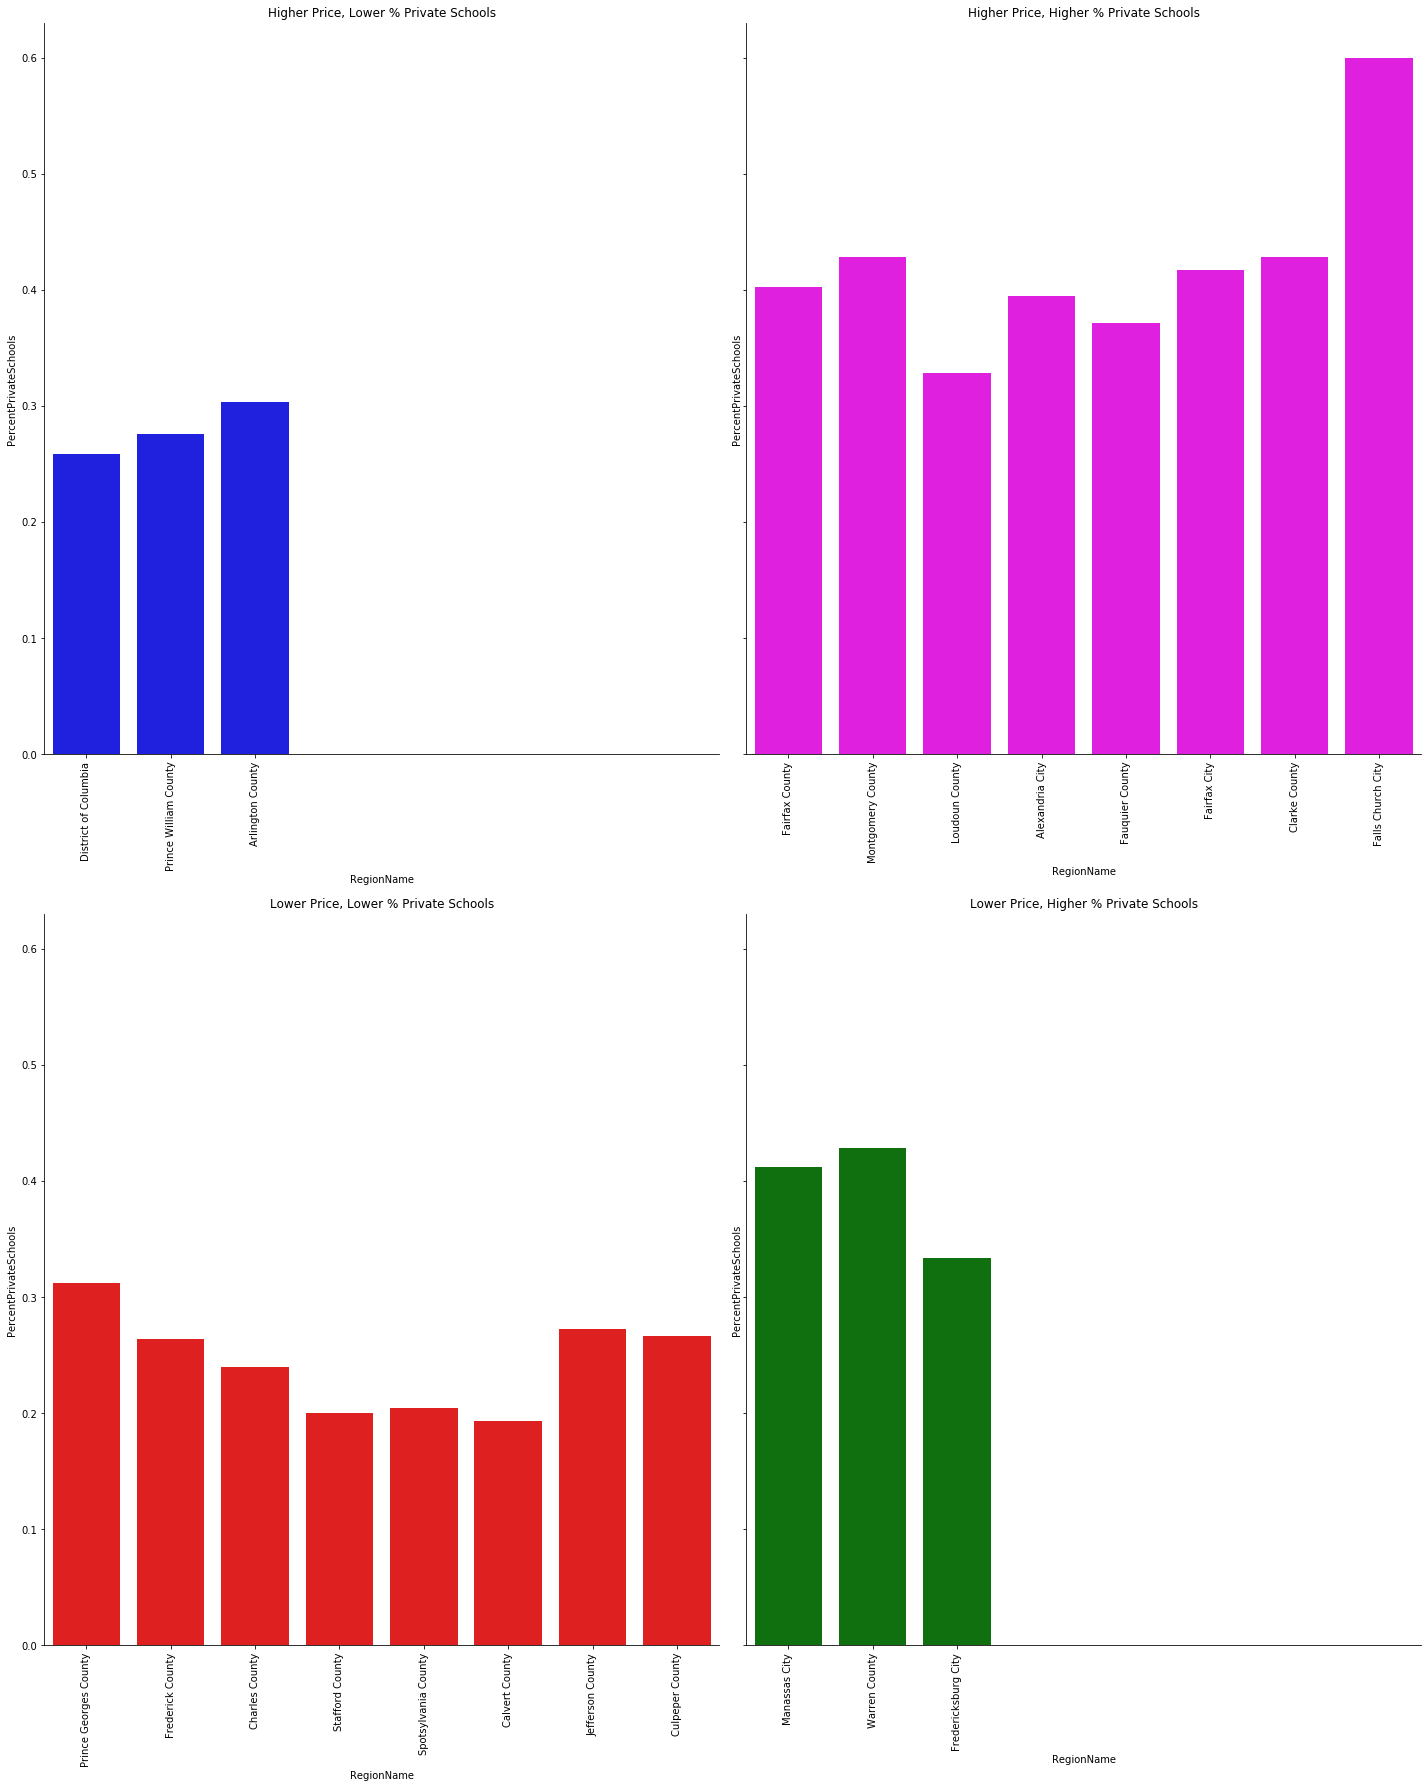

In [66]:
f, ax = plt.subplots(2, 2, figsize=(20,25), sharey=True)

plot_titles = [['Higher Price, Lower % Private Schools','Higher Price, Higher % Private Schools'],
               ['Lower Price, Lower % Private Schools','Lower Price, Higher % Private Schools']]

sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dcmetro_high_price_low_pct_private_schools['RegionName'], dcmetro_high_price_low_pct_private_schools['PercentPrivateSchools'], ax=ax[0][0], color='blue')
sns.barplot(dcmetro_high_price_high_pct_private_schools['RegionName'], dcmetro_high_price_high_pct_private_schools['PercentPrivateSchools'], ax=ax[0][1], color='magenta')
sns.barplot(dcmetro_low_price_low_pct_private_schools['RegionName'], dcmetro_low_price_low_pct_private_schools['PercentPrivateSchools'], ax=ax[1][0], color='red')
sns.barplot(dcmetro_low_price_high_pct_private_schools['RegionName'], dcmetro_low_price_high_pct_private_schools['PercentPrivateSchools'], ax=ax[1][1], color='green')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        plt.setp(ax[i][j].xaxis.get_majorticklabels(),rotation=90)
        ax[i][j].title.set_text(plot_titles[i][j])
        ax[i][j].set_xlim(-0.5,8-0.5)
        

plt.tight_layout()

In [67]:
# Z tests comparing counties with lower house prices to counties with higher house prices

In [68]:
ztest (dc_metro_low_price_counties['PeoplePerHospital'], dc_metro_high_price_counties['PeoplePerHospital'])

(0.2676751711328554, 0.7889493631674214)

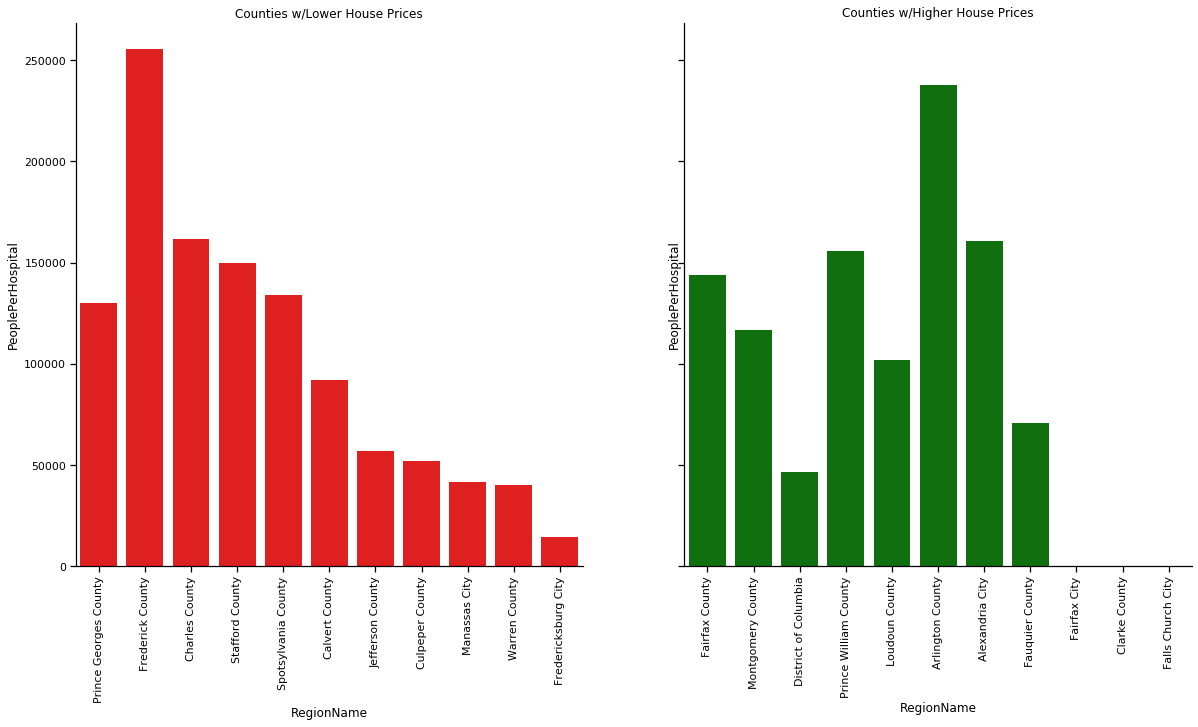

In [69]:
f, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dc_metro_low_price_counties['RegionName'], dc_metro_low_price_counties['PeoplePerHospital'], ax=ax[0], color='red')
plt.setp(ax[0].xaxis.get_majorticklabels(),rotation=90)
ax[0].title.set_text('Counties w/Lower House Prices')
sns.barplot(dc_metro_high_price_counties['RegionName'], dc_metro_high_price_counties['PeoplePerHospital'], ax=ax[1], color='green')
plt.setp(ax[1].xaxis.get_majorticklabels(),rotation=90);
ax[1].title.set_text('Counties w/Higher House Prices')

In [70]:
ztest (dc_metro_low_price_counties['PeoplePerSchool'], dc_metro_high_price_counties['PeoplePerSchool'])

(0.41487340816509116, 0.6782345773522396)

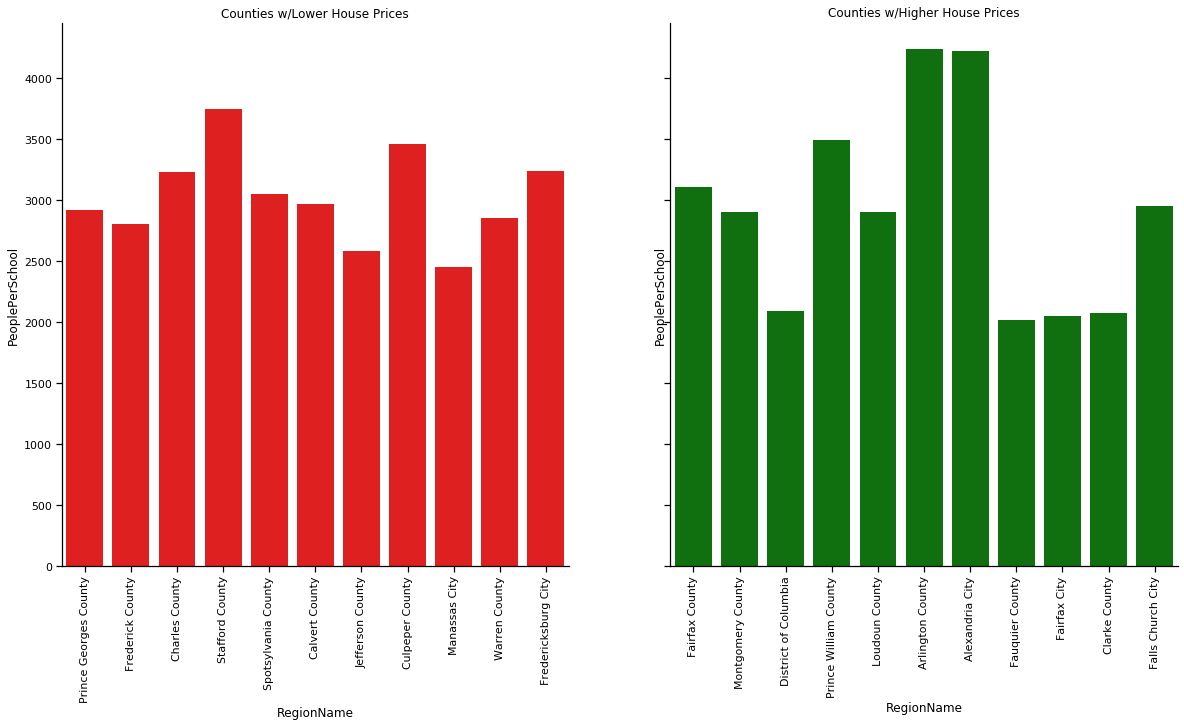

In [71]:
f, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dc_metro_low_price_counties['RegionName'], dc_metro_low_price_counties['PeoplePerSchool'], ax=ax[0], color='red')
plt.setp(ax[0].xaxis.get_majorticklabels(),rotation=90)
ax[0].title.set_text('Counties w/Lower House Prices')
sns.barplot(dc_metro_high_price_counties['RegionName'], dc_metro_high_price_counties['PeoplePerSchool'], ax=ax[1], color='green')
plt.setp(ax[1].xaxis.get_majorticklabels(),rotation=90);
ax[1].title.set_text('Counties w/Higher House Prices')

In [72]:
ztest (dc_metro_low_price_counties['PercentPrivateSchools'], dc_metro_high_price_counties['PercentPrivateSchools'])

(-2.6318370223362892, 0.008492459061615488)

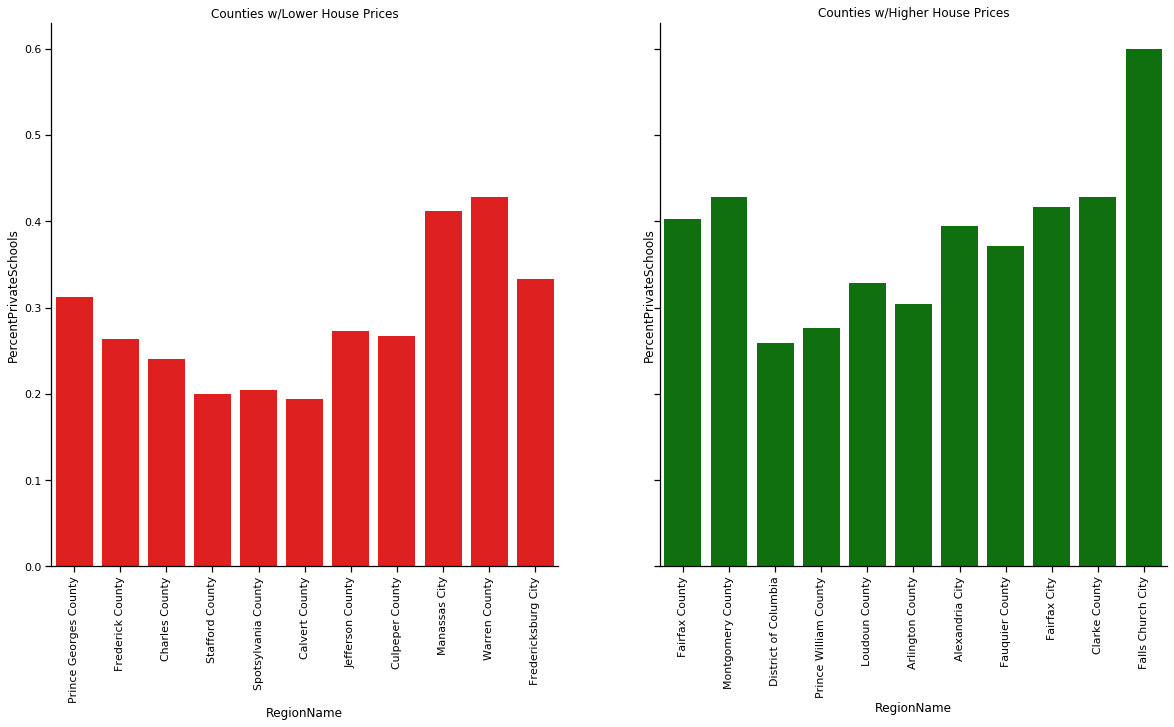

In [73]:
f, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dc_metro_low_price_counties['RegionName'], dc_metro_low_price_counties['PercentPrivateSchools'], ax=ax[0], color='red')
plt.setp(ax[0].xaxis.get_majorticklabels(),rotation=90)
ax[0].title.set_text('Counties w/Lower House Prices')
sns.barplot(dc_metro_high_price_counties['RegionName'], dc_metro_high_price_counties['PercentPrivateSchools'], ax=ax[1], color='green')
plt.setp(ax[1].xaxis.get_majorticklabels(),rotation=90);
ax[1].title.set_text('Counties w/Higher House Prices')

In [74]:
ztest (dc_metro_low_price_counties['NumberOfPrivateSchools'] / dc_metro_low_price_counties['Population'], 
       dc_metro_high_price_counties['NumberOfPrivateSchools'] / dc_metro_high_price_counties['Population'])

(-2.372554466283912, 0.017665558355976503)

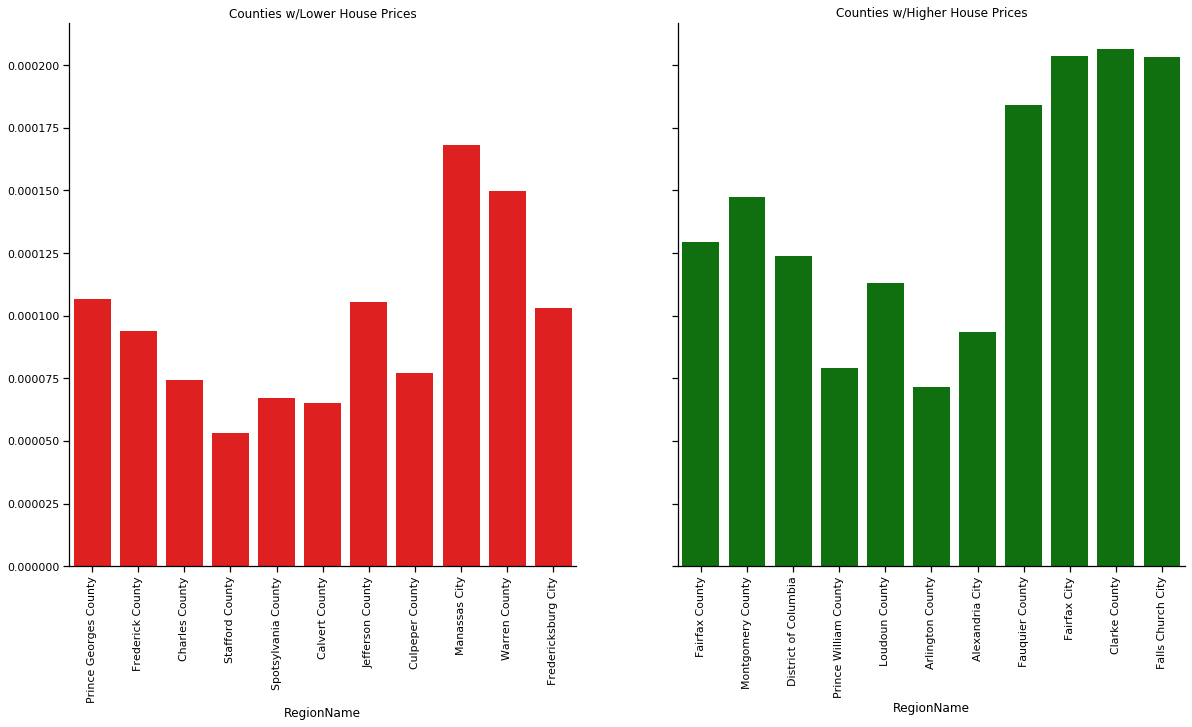

In [75]:
f, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dc_metro_low_price_counties['RegionName'], 
            dc_metro_low_price_counties['NumberOfPrivateSchools'] / dc_metro_low_price_counties['Population'], ax=ax[0], color='red')
plt.setp(ax[0].xaxis.get_majorticklabels(),rotation=90)
ax[0].title.set_text('Counties w/Lower House Prices')
sns.barplot(dc_metro_high_price_counties['RegionName'], 
            dc_metro_high_price_counties['NumberOfPrivateSchools'] / dc_metro_high_price_counties['Population'], ax=ax[1], color='green')
plt.setp(ax[1].xaxis.get_majorticklabels(),rotation=90);
ax[1].title.set_text('Counties w/Higher House Prices')

In [76]:
ztest (dc_metro_low_price_counties['NumberOfPublicSchools'] / dc_metro_low_price_counties['Population'], 
       dc_metro_high_price_counties['NumberOfPublicSchools'] / dc_metro_high_price_counties['Population'])

(0.4811415006000532, 0.6304159343470777)

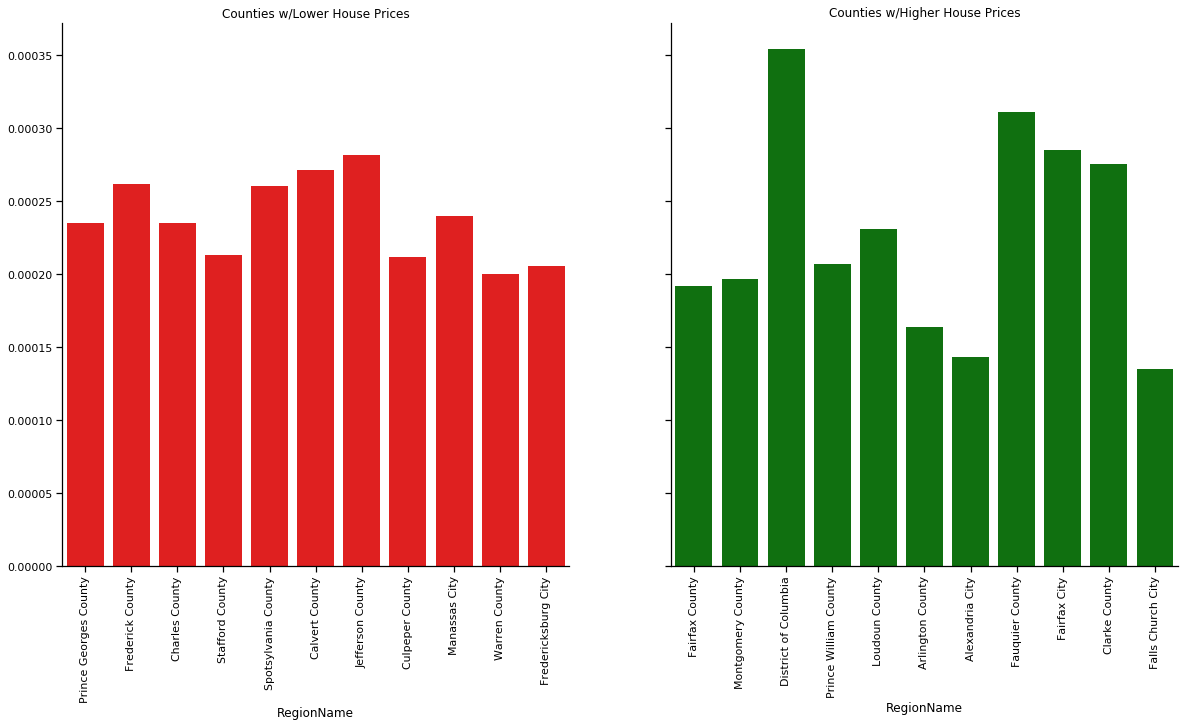

In [77]:
f, ax = plt.subplots(1, 2, figsize=(20,10), sharey=True)
sns.set_context(SEABORN_CONTEXT)
sns.despine(f)
sns.barplot(dc_metro_low_price_counties['RegionName'], dc_metro_low_price_counties['NumberOfPublicSchools'] / dc_metro_low_price_counties['Population'], ax=ax[0], color='red')
plt.setp(ax[0].xaxis.get_majorticklabels(),rotation=90)
ax[0].title.set_text('Counties w/Lower House Prices')
sns.barplot(dc_metro_high_price_counties['RegionName'], dc_metro_high_price_counties['NumberOfPublicSchools'] / dc_metro_high_price_counties['Population'], ax=ax[1], color='green')
plt.setp(ax[1].xaxis.get_majorticklabels(),rotation=90);
ax[1].title.set_text('Counties w/Higher House Prices')